In [1]:
function diffusion(T, k0, dx, ix, iz, geotherm) #add Ttop as an argument
  
    Tx = T[:, vec(ix)]
    kx = (k0[:, ix[1:end-1]] + k0[:, ix[2:end]]) ./ 2 #thermal conductivity in x direction


    Tz = T[vec(iz), :]
    Tz[1,:] .= 11.74 
    # Tx and Tz are the temperature values at the cell centres in x and z directions respectively
    kz = (k0[iz[1:end-1], :] + k0[iz[2:end], :]) ./ 2 #thermal conductivity in z direction 
    
    qx = - kx .* diff(Tx, dims=2) ./ dx #heat flux in x direction 
    qz = - kz .* diff(Tz, dims=1) ./ dx #heat flux in z direction

    qz[end, :] .= -kz[end, :] .* geotherm[2] #apply boundary condition at the bottom of the model

    dqx = diff(qx, dims=2) ./ dx #change in heat flux in x direction
    dqz = diff(qz, dims=1) ./ dx #change in heat flux in z direction

    dTdt_diffusion = - (dqx .+ dqz) #change in temperature due to diffusion
    #println(size(dTdt_diffusion))
    return dTdt_diffusion
end

diffusion (generic function with 1 method)

In [2]:
function apply_BC!(T, units, T_top)
    T[units .== 1] .= 11.74       # Air layer
    T[1, :] .= T_top              # Top Dirichlet
    T[end, :] .= T[end-1, :]      # Bottom Neumann (no flux)
    T[:, 1] .= T[:, 2]            # Left Neumann
    T[:, end] .= T[:, end-1]      # Right Neumann
end


apply_BC! (generic function with 1 method)

In [3]:
function meshgrid(x,y)
    # Create a meshgrid for the given x and y vectors
    X = repeat(x', length(y), 1)  # Repeat x across rows
    Y = repeat(y, 1, length(x))   # Repeat y across columns
    return X, Y
end

meshgrid (generic function with 1 method)

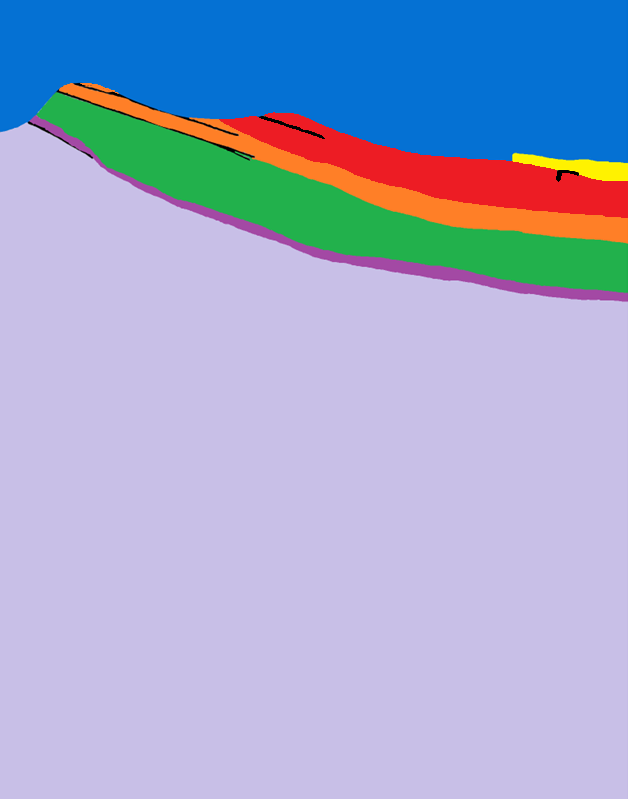

In [4]:
using Images, Plots 
pic_path = "M:/Dissertation Code/UistDomainCroppedFilled.tif" 
domain_image = load(pic_path) #load image from named pic_path 
#display(plot(domain_image, axis=nothing, title="Loaded Domain Image")) 

In [5]:
W = 3933 #width of image in metres 
Nx = 100 #specify the number of pixels in the x direction  
pic_path = "M:/Dissertation Code/UistDomainCroppedFilled.tif" #in theory, this could be changed

CFL = 


yr = 365.25 * 24 * 3600 #seconds in a year
tend = 1e6*yr #end time in years
println(tend)
#k0 = 1e-6 #diffusion coefficient in m^2/s 



3.15576e13


In [6]:
using Colors
using ImageIO
using TiffImages

function read_image(pic_path, W, Nx)

    ### READ IN THE IMAGE ###
    domain_image = load(pic_path) # load image
    
    p, q = size(domain_image)  # image dimensions (rows, cols)

    
    target_grid = zeros(Int, p, q) # array to store unit numbers

   # Define allowed colors (non-black) and their corresponding unit numbers
    target_colors = [
        [5, 113, 211],   # blue - sky
        [255, 242, 0],   # yellow - Uisinis Mylonite
        [237, 28, 36],   # red - upper Corodale Gneiss
        [255, 127, 39],  # orange - mashed/crushed gneiss
        [34, 177, 76],   # green - lower Corodale Gneiss
        [163, 73, 164],  # purple - Pseudotachylite
        [200, 191, 231]  # lilac - Basement Lewisian Gneiss
    ]

    fracture_color = [0, 0, 0]  # black - fractures
    tolerance = 20  # in 0-255 integer RGB space

    # Loop over pixels
    for i in 1:p, j in 1:q
        pixel_rgb = domain_image[i,j]
        pixel_int = round.(Int, 255 .* [red(pixel_rgb), green(pixel_rgb), blue(pixel_rgb)])

        # Check for fractures first: avoid assigning any pixel to black
        if all(abs.(pixel_int .- fracture_color) .<= tolerance)
            target_grid[i,j] = 8  # unit number for fractures
            continue
        end

        # Compute distances to all allowed colors
        dists = [norm(pixel_int .- c) for c in target_colors]
        closest_unit = argmin(dists)  # index of the closest color in target_colors

        target_grid[i,j] = closest_unit  # assign corresponding unit number
    end


    ### DEFINE GRID SIZES ###
    D = W * p / q
    Nz = floor(Int, Nx * p / q)

    ### IMAGE GRID ###
    img_h = W / q
    img_xc = range(img_h/2, stop=W - img_h/2, length=q)
    img_zc = range(img_h/2, stop=D - img_h/2, length=p)
    XCimg, ZCimg = meshgrid(img_xc, img_zc)

    ### MODEL GRID ###
    h = W / Nx
    xc = range(h/2, stop=W - h/2, length=Nx)
    zc = range(h/2, stop=D - h/2, length=Nz)
    XC, ZC = meshgrid(xc, zc)

    ### INTERPOLATE TO MODEL GRID ###
    interp_img_units = zeros(Int, Nz, Nx)
    for i in 1:Nz, j in 1:Nx
        # find closest image pixel in x and z
        closest_x = findmin(abs.(img_xc .- XC[i,j]))[2]
        closest_z = findmin(abs.(img_zc .- ZC[i,j]))[2]
        interp_img_units[i,j] = target_grid[closest_z, closest_x]
    end

    units = Int.(interp_img_units)
    return units, D, Nz, h
end


read_image (generic function with 1 method)

In [7]:
units, D, Nz, h = read_image(pic_path, W, Nx)

println("Domain size: ", D, " m, Nz: ", Nz, " h: ", h)

matprop = [
 #   sigma      rho0       Cp        Hr            # Material properties   
 1   1e-6    1           1000      0            # Sky:: DONE 
 2   2.467   2700.0       874.5    2.9e-6       # Yellow: Mylonite 
 3   3.218   2703.5      1000      5.575e-6     # Red :Corodale Gneiss 
 4   0.25    1000        932      1e-6         # Orange: Crushged and Altered Corodale Gneiss 
 5   0.65    1000        566      1e-6         # Green: Corodale Gneiss
 6   1.3     2091.8       878      1e-6         # Purple: Pseudotachylite  
 7   0.39    1000        1088      1e-6         # Lilac: Basement Gneiss 
 8   1e-6    1           1000      0             #Black: Fracture (air / water)

]


sigma = matprop[units, 2] #this is the thermal conductivity in W/m/K
rho0 = matprop[units, 3]
Cp = matprop[units, 4]
Hr = matprop[units, 5] 

t_gradient = 35 / 1000
geotherm = [0.0, t_gradient]
Ttop = 11.74 #temperature at the top of the model in degrees Celsius

yr = 60 * 60 * 24 * 365.25
endT = 1e6 * yr
CFL = 0.8
nop = 10000

dTdto = 0.0

a = rho0 .* Cp

kT0 = sigma ./ a  #thermal diffusivity in m^2/s 






Domain size: 5003.928343949045 m, Nz: 127 h: 39.33


127×100 Matrix{Float64}:
 1.0e-9      1.0e-9      1.0e-9      …  1.0e-9      1.0e-9      1.0e-9
 1.0e-9      1.0e-9      1.0e-9         1.0e-9      1.0e-9      1.0e-9
 1.0e-9      1.0e-9      1.0e-9         1.0e-9      1.0e-9      1.0e-9
 1.0e-9      1.0e-9      1.0e-9         1.0e-9      1.0e-9      1.0e-9
 1.0e-9      1.0e-9      1.0e-9         1.0e-9      1.0e-9      1.0e-9
 1.0e-9      1.0e-9      1.0e-9      …  1.0e-9      1.0e-9      1.0e-9
 1.0e-9      1.0e-9      1.0e-9         1.0e-9      1.0e-9      1.0e-9
 1.0e-9      1.0e-9      1.0e-9         1.0e-9      1.0e-9      1.0e-9
 1.0e-9      1.0e-9      1.0e-9         1.0e-9      1.0e-9      1.0e-9
 1.0e-9      1.0e-9      1.0e-9         1.0e-9      1.0e-9      1.0e-9
 ⋮                                   ⋱                          
 3.58456e-7  3.58456e-7  3.58456e-7     3.58456e-7  3.58456e-7  3.58456e-7
 3.58456e-7  3.58456e-7  3.58456e-7     3.58456e-7  3.58456e-7  3.58456e-7
 3.58456e-7  3.58456e-7  3.58456e-7  …  3.58456e-7

In [8]:
using StatsBase  # for countmap

unit_counts = countmap(vec(units))  # flatten to 1D before counting
println(unit_counts)

println(Nx*Nz)

println(units)

Dict(5 => 819, 4 => 293, 6 => 153, 7 => 8929, 2 => 41, 8 => 10, 3 => 385, 1 => 2070)
12700
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1; 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

In [9]:
ix = reshape(vcat(1, collect(1:Nx), Nx), 1, :)  #'create a padded vector with a cushion of 1 and Nx on each end 
iz = reshape(vcat(1, collect(1:Nz), Nz), :, 1) #do the same in the z direction  

cell_width = W / Nx #calculate the cell width in the model 
cell_x_centres = range(cell_width/2, stop=W - cell_width/2; length=Nx) #calculate the x coordinates of the cell centres
cell_z_centres = range(cell_width/2, stop=D - cell_width/2; length=Nz) #calculate the z coordinates of the cell centres 

XC, ZC = meshgrid(cell_x_centres, cell_z_centres) #create a meshgrid of the cell centres for plotting

T = Ttop .+ geotherm[2].*ZC  #calculate the temperature at each depth based on the top temperature and the geothermal gradient 
T_insant = T #store the current temperature for test plotting 
Tbottom = Ttop + geotherm[2] * D / 1000 #calculate the bottom temperature based on the top temperature and the geothermal gradient
Tair = Ttop 

#dt = CFL * ((cell_width/2)^2)/maximum(kT0)
dt = CFL * (cell_width^2) / (4 * maximum(kT0))

println(maximum(kT0), " W/m/K") #print the maximum thermal conductivity in the model

println("Time step size: ", dt, " seconds")


1.1903088588866284e-6 W/m/K
Time step size: 2.599071473679304e8 seconds


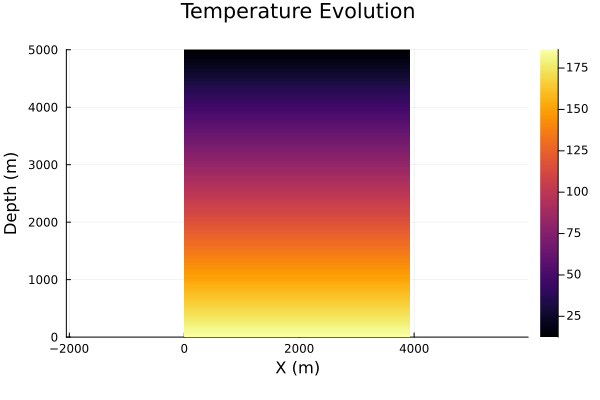

Step: 10000 | Time: 2.59907147367958e12 s | Avg T: 99.18°C | Min: 11.74°C | Max: 148.47°C | ΔTmax: 0.0021°C
Step: 20000 | Time: 5.19814294736122e12 s | Avg T: 99.24°C | Min: 11.74°C | Max: 134.26°C | ΔTmax: 0.0013°C
Step: 30000 | Time: 7.79721442104286e12 s | Avg T: 99.35°C | Min: 11.74°C | Max: 125.85°C | ΔTmax: 0.0009°C
Step: 40000 | Time: 1.039628589471849e13 s | Avg T: 99.48°C | Min: 11.74°C | Max: 120.91°C | ΔTmax: 0.0008°C
Step: 50000 | Time: 1.299535736839036e13 s | Avg T: 99.64°C | Min: 11.74°C | Max: 117.96°C | ΔTmax: 0.0006°C
Step: 60000 | Time: 1.559442884206224e13 s | Avg T: 99.8°C | Min: 11.74°C | Max: 116.2°C | ΔTmax: 0.0005°C
Step: 70000 | Time: 1.819350031573412e13 s | Avg T: 99.97°C | Min: 11.74°C | Max: 115.14°C | ΔTmax: 0.0004°C
Step: 80000 | Time: 2.079257178940599e13 s | Avg T: 100.14°C | Min: 11.74°C | Max: 114.51°C | ΔTmax: 0.0004°C
Step: 90000 | Time: 2.339164326307786e13 s | Avg T: 100.31°C | Min: 11.74°C | Max: 114.14°C | ΔTmax: 0.0003°C
Step: 100000 | Time: 2

In [10]:
t=0 
k=0 
dTdt = 0 

# Set up the initial heatmap and store handle
plt = heatmap(
    cell_x_centres,
    cell_z_centres,
    reverse(T, dims = 1);
    aspect_ratio = :equal,
    colorbar = true,
    xlabel = "X (m)",
    ylabel = "Depth (m)",
    title = "Temperature Evolution",
    flipy = true,
    clim = (minimum(T), maximum(T))
)

display(plt)

using Statistics 

while t <= tend
    # Increment time and step count
    t += dt
    k += 1

    # Store old temperature and rate
    dTdto = dTdt
    To = copy(T)


    # Compute rate of change using Runge-Kutta 4th order method
    dTdt1 = diffusion(T, kT0, h, ix, iz, geotherm)
    dTdt2 = diffusion(T .+ dTdt1 .* (dt/2), kT0, h, ix, iz, geotherm)
    dTdt3 = diffusion(T .+ dTdt2 .* (dt/2), kT0, h, ix, iz, geotherm)
    dTdt4 = diffusion(T .+ dTdt3 .* dt,    kT0, h, ix, iz, geotherm)

    # Calculate heat source contribution 
    Hs = (Hr .* 1e-6) ./ (rho0 .* Cp)

    # Update temperature using the RK4 method 
    T .= T .+ (dTdt1 .+ 2 .* dTdt2 .+ 2 .* dTdt3 .+ dTdt4) .* (dt/6) .+ Hs

    # Apply BC once
    T[1,:] .= 11.74       # top boundary (constant air temp)
    T[end,:] .= T[end-1,:]   # bottom Neumann
    T[:,1] .= T[:,2]     # left Neumann
    T[:,end] .= T[:,end-1]   # right Neumann

    
    # Compute some simple statistics
    avgT   = mean(T)
    minT   = minimum(T)
    maxT   = maximum(T)
    deltaT = maximum(abs.(T .- To))  # max absolute change since last step

    # Print progress every `nop` steps (or a different interval if you want)
    if k % nop == 0
        avgT   = mean(T)
        minT   = minimum(T)
        maxT   = maximum(T)
        deltaT = maximum(abs.(T .- To))
    
        println("Step: $k | Time: $(round(t, digits=2)) s | ",
                "Avg T: $(round(avgT, digits=2))°C | ",
                "Min: $(round(minT, digits=2))°C | ",
                "Max: $(round(maxT, digits=2))°C | ",
                "ΔTmax: $(round(deltaT, digits=4))°C")
    end

    # Plot every 'nop' time steps
    #if k % nop == 0
    #    plot!(plt, cell_x_centres, cell_z_centres, reverse(T); seriestype=:heatmap)
    #    gui()       # refresh plot window
    #    sleep(0.01) # give GUI time to update
    #end

end

        # After the loop ends, store the final values
        T_final    = copy(T)          # final temperature array
        Tmax_final = maximum(T_final) # final maximum temperature
        Tmin_final = minimum(T_final) # final minimum temperature
        Tavg_final = mean(T_final)    # final average temperature
        
        println("Final Tmax = $Tmax_final °C")
        println("Final Tmin = $Tmin_final °C")
        println("Final Avg T = $Tavg_final °C")



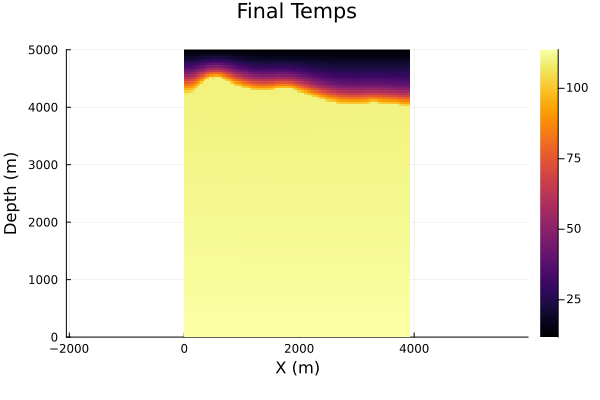

In [15]:
using Plots

# Create heatmap of final temperature with scaled colorbar
plt = heatmap(
    cell_x_centres,
    cell_z_centres,
    reverse(T_final, dims = 1);  # use the final temperature array
    aspect_ratio = :equal,
    colorbar = true,
    xlabel = "X (m)",
    ylabel = "Depth (m)",
    title = "Final Temps",
    flipy = true,
    clim = (Tmin_final, Tmax_final)  # scale colorbar from final min to final max
)

display(plt)


In [16]:
function advection()

    
end 

Base.Meta.ParseError: ParseError:
# Error @ m:\Dissertation Code\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X14sZmlsZQ==.jl:1:23
function advection()
#                   
└ ── premature end of input